# **Домашнее задание к семинару 05 (HW05)**

**Тема:** линейные модели и честный ML-эксперимент (логистическая регрессия, бейзлайн, метрики)

**Цель:** закрепить:
- базовые навыки работы с линейными моделями в scikit-learn (логистическая регрессия для бинарной классификации);
- умение строить и интерпретировать простые бейзлайны (DummyClassifier) и сравнивать их с моделями;
- навыки постановки честного ML-эксперимента: train/test-сплит, выбор признаков, подбор простых гиперпараметров;
- работу с метриками качества модели (accuracy, ROC-AUC; при желании – дополнительные метрики);
- оформление результатов эксперимента в виде аккуратного ноутбука с кодом и текстовыми выводами.

### **1. Загрузка данных и первичный осмотр**

**1.1. Импортировать необходимые библиотеки**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, auc,
    precision_score, recall_score, f1_score, confusion_matrix,
    average_precision_score, precision_recall_curve
)

sns.set(style="whitegrid")
%matplotlib inline

**1.2. Загрузить учебный датасет**

In [4]:
url = "https://raw.githubusercontent.com/mirea-aie-2025/aie-course-meta/refs/heads/main/seminars/S05/S05-hw-dataset.csv"
df = pd.read_csv(url)
print('Датасет успешно импортирован' if not df.empty else 'Датасет не импортирован')

Датасет успешно импортирован


**1.3. Выполнить первичный осмотр данных**

In [5]:
display(df.head())       # первые строки датасета
display(df.info())       # информация о столбцах и типах
display(df.describe())   # базовые описательные статистики

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

None

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000


In [15]:
print("\nРаспределение целевого признака 'default':")
print(df['default'].value_counts(normalize=True)) # соотношение классов


Распределение целевого признака 'default':
default
0    0.589667
1    0.410333
Name: proportion, dtype: float64


***После первичного осмотра датасета было выявлено:***
1. ***Структура данных:*** около 3000 строк и 17 признаков
2. ***Особенности данных:***
- years_employed минимальное значение 0 лет (новые сотрудники)
- checking_balance минимальное значение -3000 (отрицательный баланс)
- debt_to_income достигает 0.878 (высокий уровень долговой нагрузки)
- num_credit_cards, num_late_payments и active_loans есть нулевые значения
3. ***Баланс классов:*** default=1 около 40%, default=0 около 60%

### **2. Подготовка признаков и таргета**

**2.1. Выделить матрицу признаков X и вектор таргета y**

In [11]:
X = df.drop(columns=['client_id', 'default']) # исключение client_id и целевой переменной
y = df['default']

### **3. Train/Test-сплит и бейзлайн-модель**

**3.1. Разделенить на обучающую и тестовую выборки**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=666, stratify=y
)

**3.2. Построить бейзлайн-модель на основе DummyClassifier**

In [16]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

,strategy,'most_frequent'
,random_state,None
,constant,None


**3.3. Оценить бейзлайн по крайней мере по двум метрикам accuracy и ROC-AUC**

In [28]:
y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

acc_dummy = accuracy_score(y_test, y_pred_dummy)
roc_dummy = roc_auc_score(y_test, y_proba_dummy)

**3.4. Вывести значения метрик и коротко прокомментировать, что делает бейзлайн и почему важно иметь точку отсчёта**

In [29]:
print(f"Accuracy: {acc_dummy:.4f} \nROC-AUC:  {roc_dummy:.4f}")

Accuracy: 0.5893 
ROC-AUC:  0.5000


*Бейзлайн предсказывает наиболее частый класс без учёта признаков. В результате accuracy равна 0.5893, что соответствует частоте доминирующего класса (0), а ROC-AUC равна 0.5, что отражает полное отсутствие способности различать классы.* 

*Бейзлайн важен как точка отсчёта, потому что показывает минимальный уровень, выше которого должна быть любая обученная модель, чтобы считаться полезной.*

### **4. Логистическая регрессия и подбор гиперпараметров**

**4.1. Построить Pipeline, состоящий минимум из StandardScaler и LogisticRegression**

In [30]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=666))
])

**4.2. Подобрать параметр регуляризации C**

In [52]:
C_values = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
best_auc = 0
best_C = None
best_pipe = None

for C in C_values:
    pipe.set_params(logreg__C=C)
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_proba)
    print(f"C={C} -> ROC-AUC: {auc_score:.4f}")
    if auc_score > best_auc:
        best_auc = auc_score
        best_C = C
        best_pipe = pipe

print(f"\nЛучший параметр C: {best_C}, ROC-AUC на тесте: {best_auc:.4f}")

C=1e-06 -> ROC-AUC: 0.8652
C=1e-05 -> ROC-AUC: 0.8652
C=0.0001 -> ROC-AUC: 0.8652
C=0.001 -> ROC-AUC: 0.8645
C=0.01 -> ROC-AUC: 0.8628
C=0.1 -> ROC-AUC: 0.8614
C=1.0 -> ROC-AUC: 0.8611

Лучший параметр C: 1e-05, ROC-AUC на тесте: 0.8652


**4.3. Для лучшей найденной модели посчитать на тестовой выборке**

In [53]:
y_pred_best = best_pipe.predict(X_test)
y_proba_best = best_pipe.predict_proba(X_test)[:,1]

acc_best = accuracy_score(y_test, y_pred_best)
prec_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
cm_best = confusion_matrix(y_test, y_pred_best)

print(f"Accuracy:  {acc_best:.4f}")
print(f"ROC-AUC:   {best_auc:.4f}")
print(f"Precision: {prec_best:.4f}")
print(f"Recall:    {recall_best:.4f}")
print(f"F1:        {f1_best:.4f}")
print("\nConfusion matrix:\n", cm_best)

Accuracy:  0.7840
ROC-AUC:   0.8652
Precision: 0.7450
Recall:    0.7208
F1:        0.7327

Confusion matrix:
 [[366  76]
 [ 86 222]]


**4.4. Построить хотя бы один график ROC-кривой или PR-кривой**

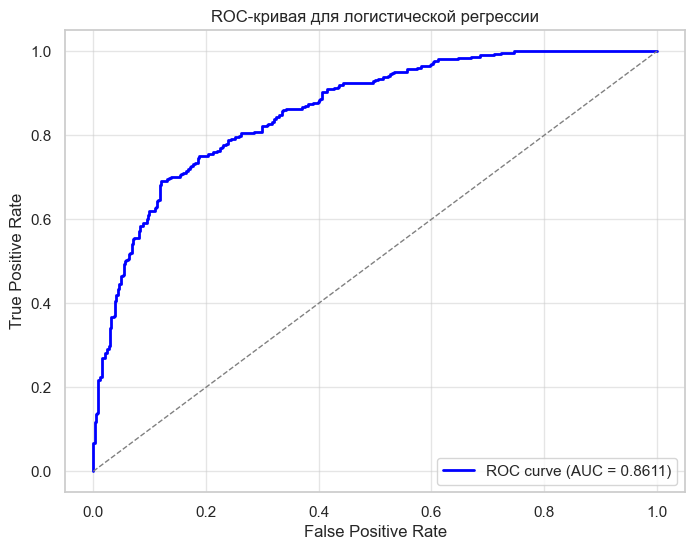

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для логистической регрессии')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.savefig("figures/roc_curve_logreg.png", dpi=300, bbox_inches='tight')
plt.show()

### **5. Сравненить бейзлайн и логистическую регрессию, написать текстовые выводы**

**5.1. Свести результаты в компактный вид**

In [55]:
results = pd.DataFrame({
    'Model': ['DummyClassifier', 'LogisticRegression'],
    'Accuracy': [acc_dummy, acc_best],
    'ROC-AUC': [roc_dummy, roc_auc]
})
display(results)

,Model,Accuracy,ROC-AUC
0,DummyClassifier,0.589333,0.500000
1,LogisticRegression,0.784000,0.861124


*Бейзлайн-модель DummyClassifier предсказывает наиболее частый класс и не использует информацию из признаков, поэтому её качество ограничено: accuracy равно 0.59, а ROC-AUC равно 0.5. Логистическая регрессия показывает существенно лучшие результаты: accuracy равно 0.78, а ROC-AUC равно до 0.86.*

*При малых значениях C (сильная регуляризация) модель показывала наилучший и стабильный ROC-AUC. По мере увеличения C качество постепенно снижалось, что указывает на ухудшение обобщающей способности.*

*В данной задаче предпочтительнее использовать более сильную регуляризацию и логистическую регрессию.*

### **6. Опциональная часть**

**6.1. Дополнительно построить графики и рассчитать метрики**

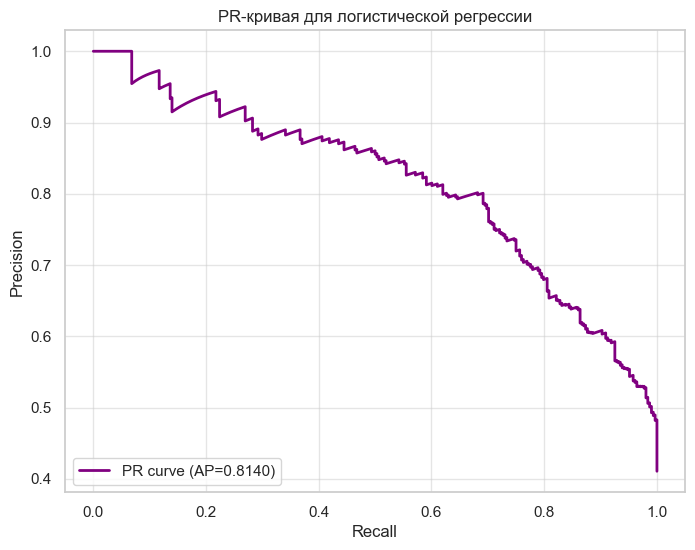

Average Precision для лучшей модели: 0.8140


In [56]:
avg_prec = average_precision_score(y_test, y_proba_best)
precision, recall, _ = precision_recall_curve(y_test, y_proba_best)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AP={avg_prec:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-кривая для логистической регрессии')
plt.legend(loc='lower left')
plt.grid(alpha=0.5)
plt.savefig("figures/pr_curve_logreg.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Average Precision для лучшей модели: {avg_prec:.4f}")